This notebook analyzes results obtained by the exact method and the neural network model trained on 36,000 images. The dataset used for training contained images with different kind of noise. The details about the dataset are presented below:<br>



Training set:<br>
* 6,000 pure images
* 6,000 images with noise obtained by averaging original images from the laboratory
* 6,000 images with triangle noise
* 6,000 images with bubble noise
* 6,000 images with a blackbox
* 6,000 images with all noises combined together


Validation set used during the training contained the same kind of images - 1,000 from each group


<b>Test set used for evaluating the neural network model and the exact method contained in total 18,000 images - from each group 3,000 pictures</b>


Below we present a sample image from each group:




In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

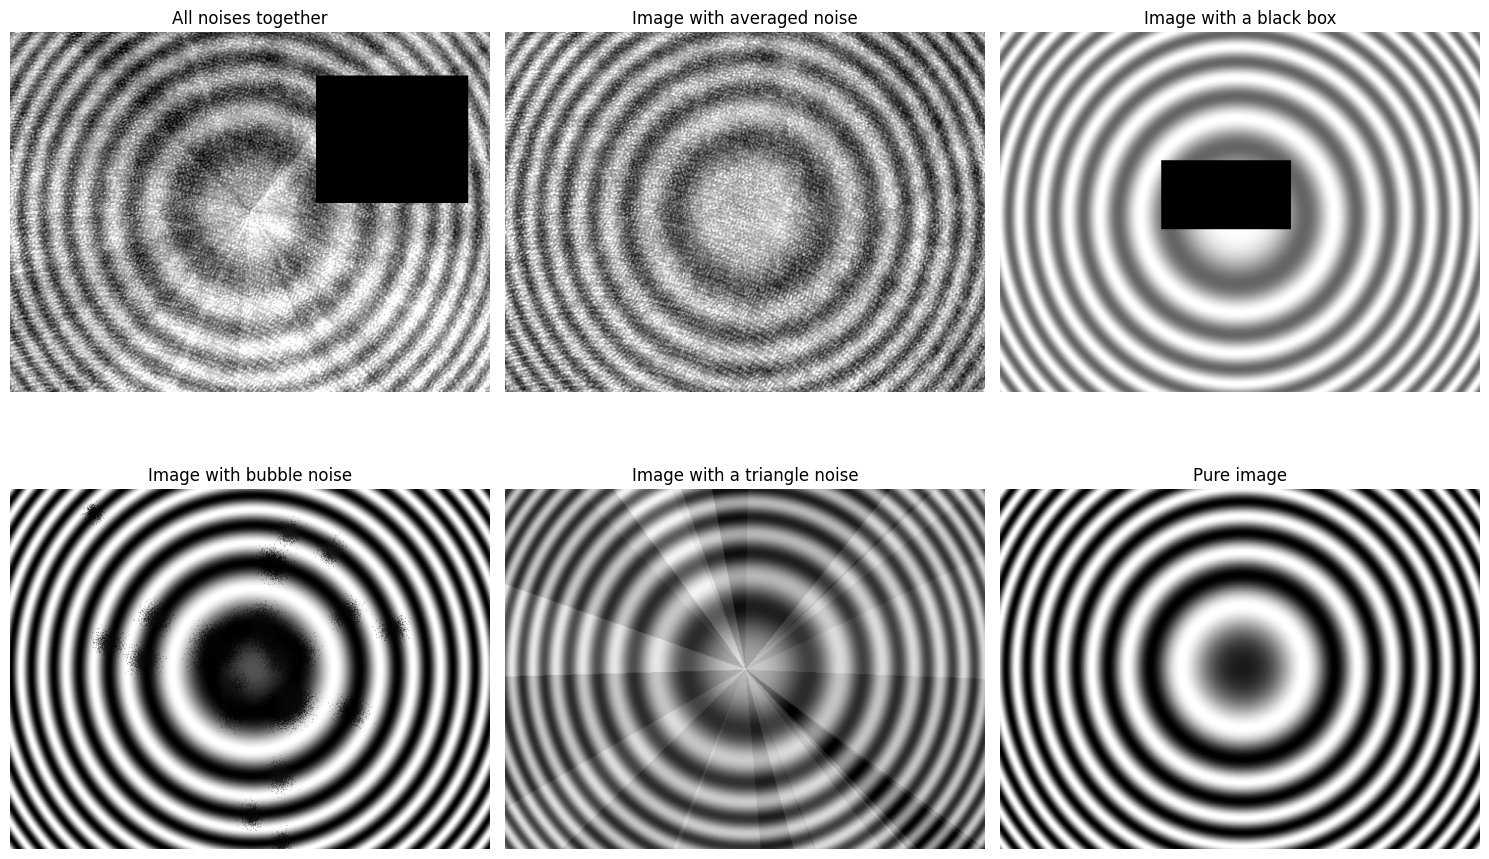

In [2]:
image_paths = [
    "../data/samples/all_00004.png",
    "../data/samples/average_00998.png",
    "../data/samples/blackbox_09956.png",
    "../data/samples/bubble_06956.png",
    "../data/samples/pizza_08956.png",
    "../data/samples/pure_03956.png",
]

titles = [
    "All noises together",
    "Image with averaged noise",
    "Image with a black box",
    "Image with bubble noise",
    "Image with a triangle noise",
    "Pure image",
]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
for i, (path, title) in enumerate(zip(image_paths, titles)):
    img = mpimg.imread(path)
    axs[i].imshow(img, cmap="gray")
    axs[i].set_title(title)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Analysis of the results

In [3]:
# Load results for the model trained on all noises together
path = "../data/results/ceramic/all_noises_together_model/"
all_noise_df = pd.read_csv(f"{path}all_model-all_noise_results.csv")
average_noise_df = pd.read_csv(f"{path}all_model-average_noise_results.csv")
blackbox_noise_df = pd.read_csv(f"{path}all_model-blackbox_noise_results.csv")
bubble_noise_df = pd.read_csv(f"{path}all_model-bubble_noise_results.csv")
pizza_noise_df = pd.read_csv(f"{path}all_model-pizza_noise_results.csv")
pure_noise_df = pd.read_csv(f"{path}all_model-pure_noise_results.csv")

dfs = {
    "all_noise": all_noise_df,
    "average_noise": average_noise_df,
    "blackbox_noise": blackbox_noise_df,
    "bubble_noise": bubble_noise_df,
    "triangle_noise": pizza_noise_df,
    "pure_noise": pure_noise_df,
}

In [4]:
# Load results for the exact method
exact_path = "../data/results/ceramic/exact_method/"
exact_all_noise_df = pd.read_csv(f"{exact_path}exact_method-all_noise_results.csv")
exact_average_noise_df = pd.read_csv(
    f"{exact_path}exact_method-average_noise_results.csv"
)
exact_blackbox_noise_df = pd.read_csv(
    f"{exact_path}exact_method-blackbox_noise_results.csv"
)
exact_bubble_noise_df = pd.read_csv(
    f"{exact_path}exact_method-bubble_noise_results.csv"
)
exact_pizza_noise_df = pd.read_csv(f"{exact_path}exact_method-pizza_noise_results.csv")
exact_pure_noise_df = pd.read_csv(f"{exact_path}exact_method-pure_noise_results.csv")

exact_dfs = {
    "all_noise": exact_all_noise_df,
    "average_noise": exact_average_noise_df,
    "blackbox_noise": exact_blackbox_noise_df,
    "bubble_noise": exact_bubble_noise_df,
    "triangle_noise": exact_pizza_noise_df,
    "pure_noise": exact_pure_noise_df,
}

### Neural network model: the absolute loss for each testset ###

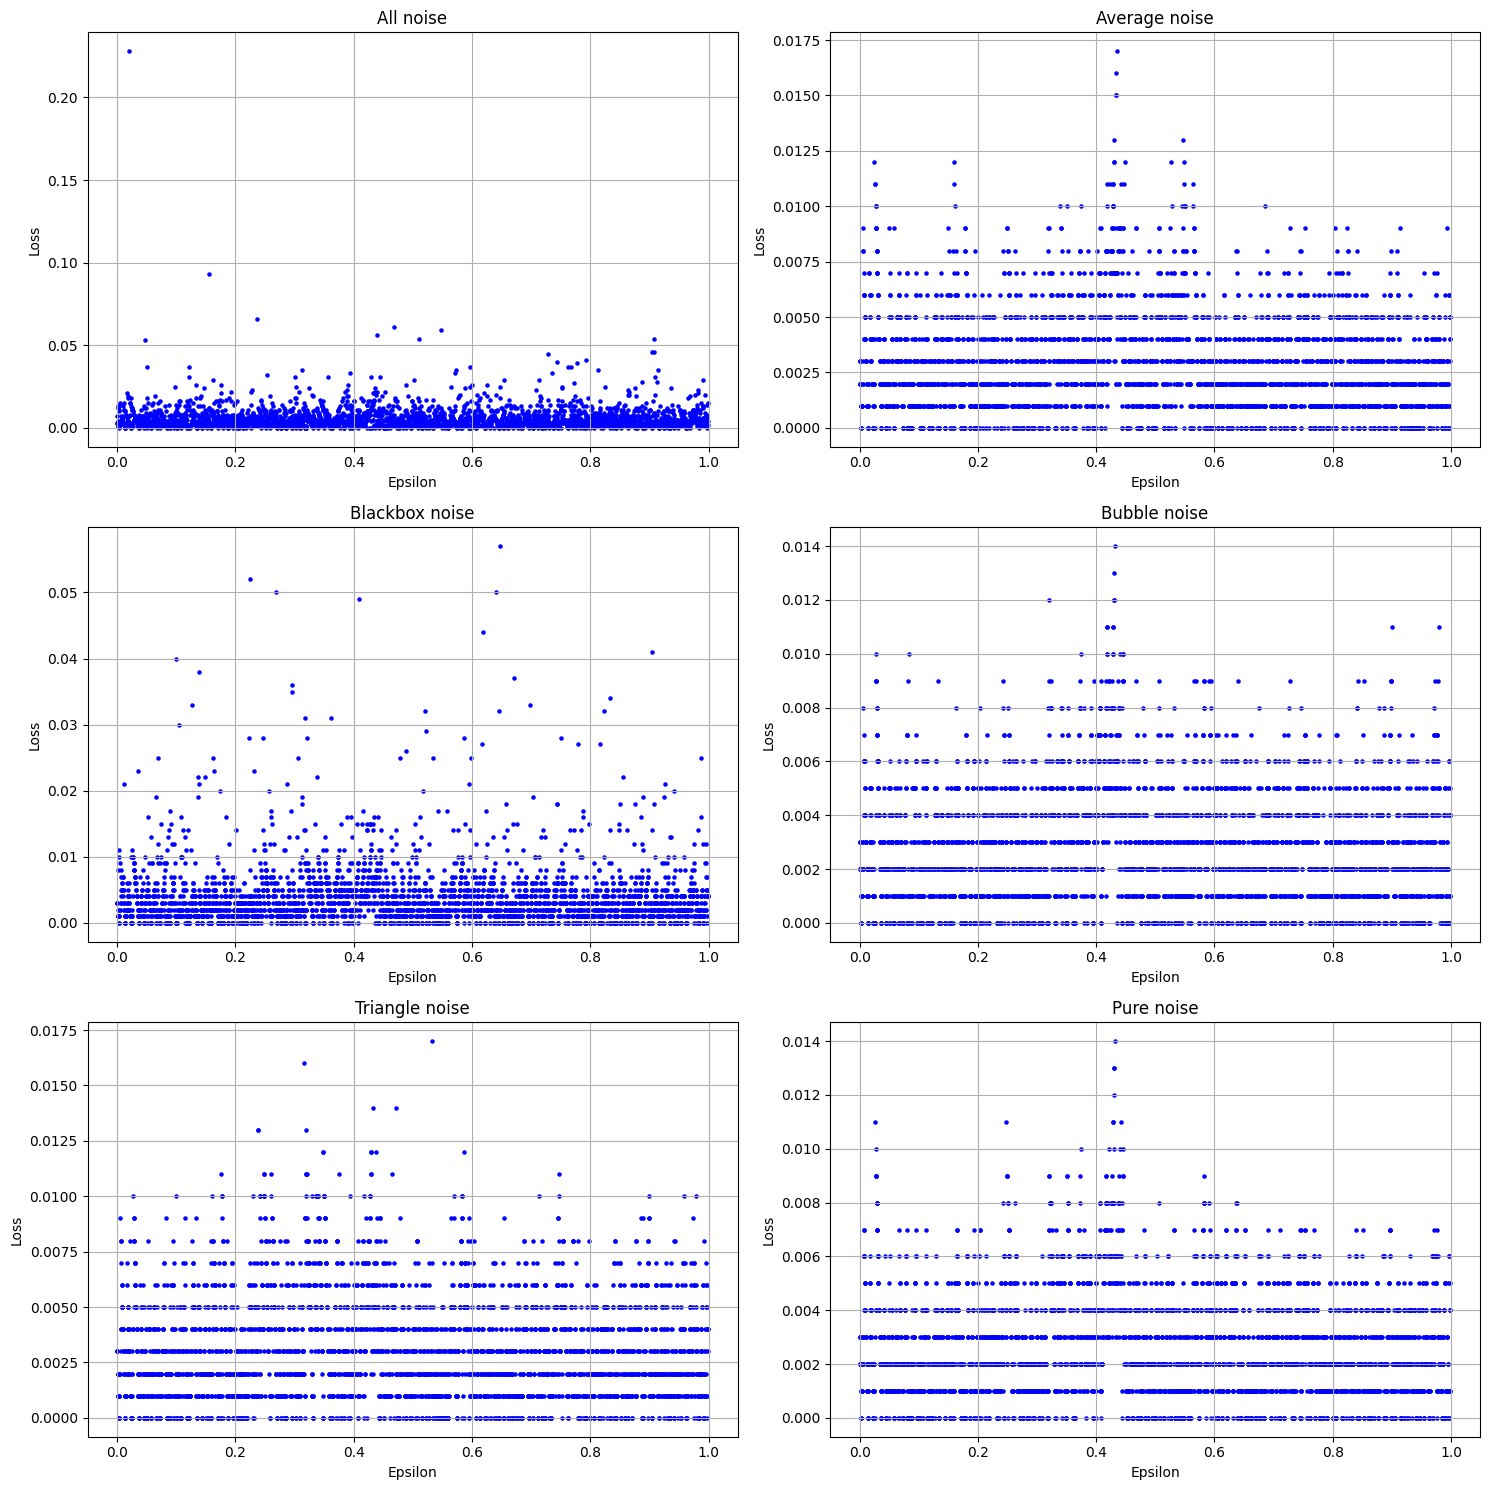

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for ax, (name, df) in zip(axes.ravel(), dfs.items()):
    df_sorted = df.sort_values(by="epsilon")
    ax.scatter(df_sorted["epsilon"], df_sorted["loss"], label=name, color="blue", s=5)
    ax.set_title(name.replace("_", " ").capitalize())
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Loss")
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### The exact method: the absolute loss for each testset ###

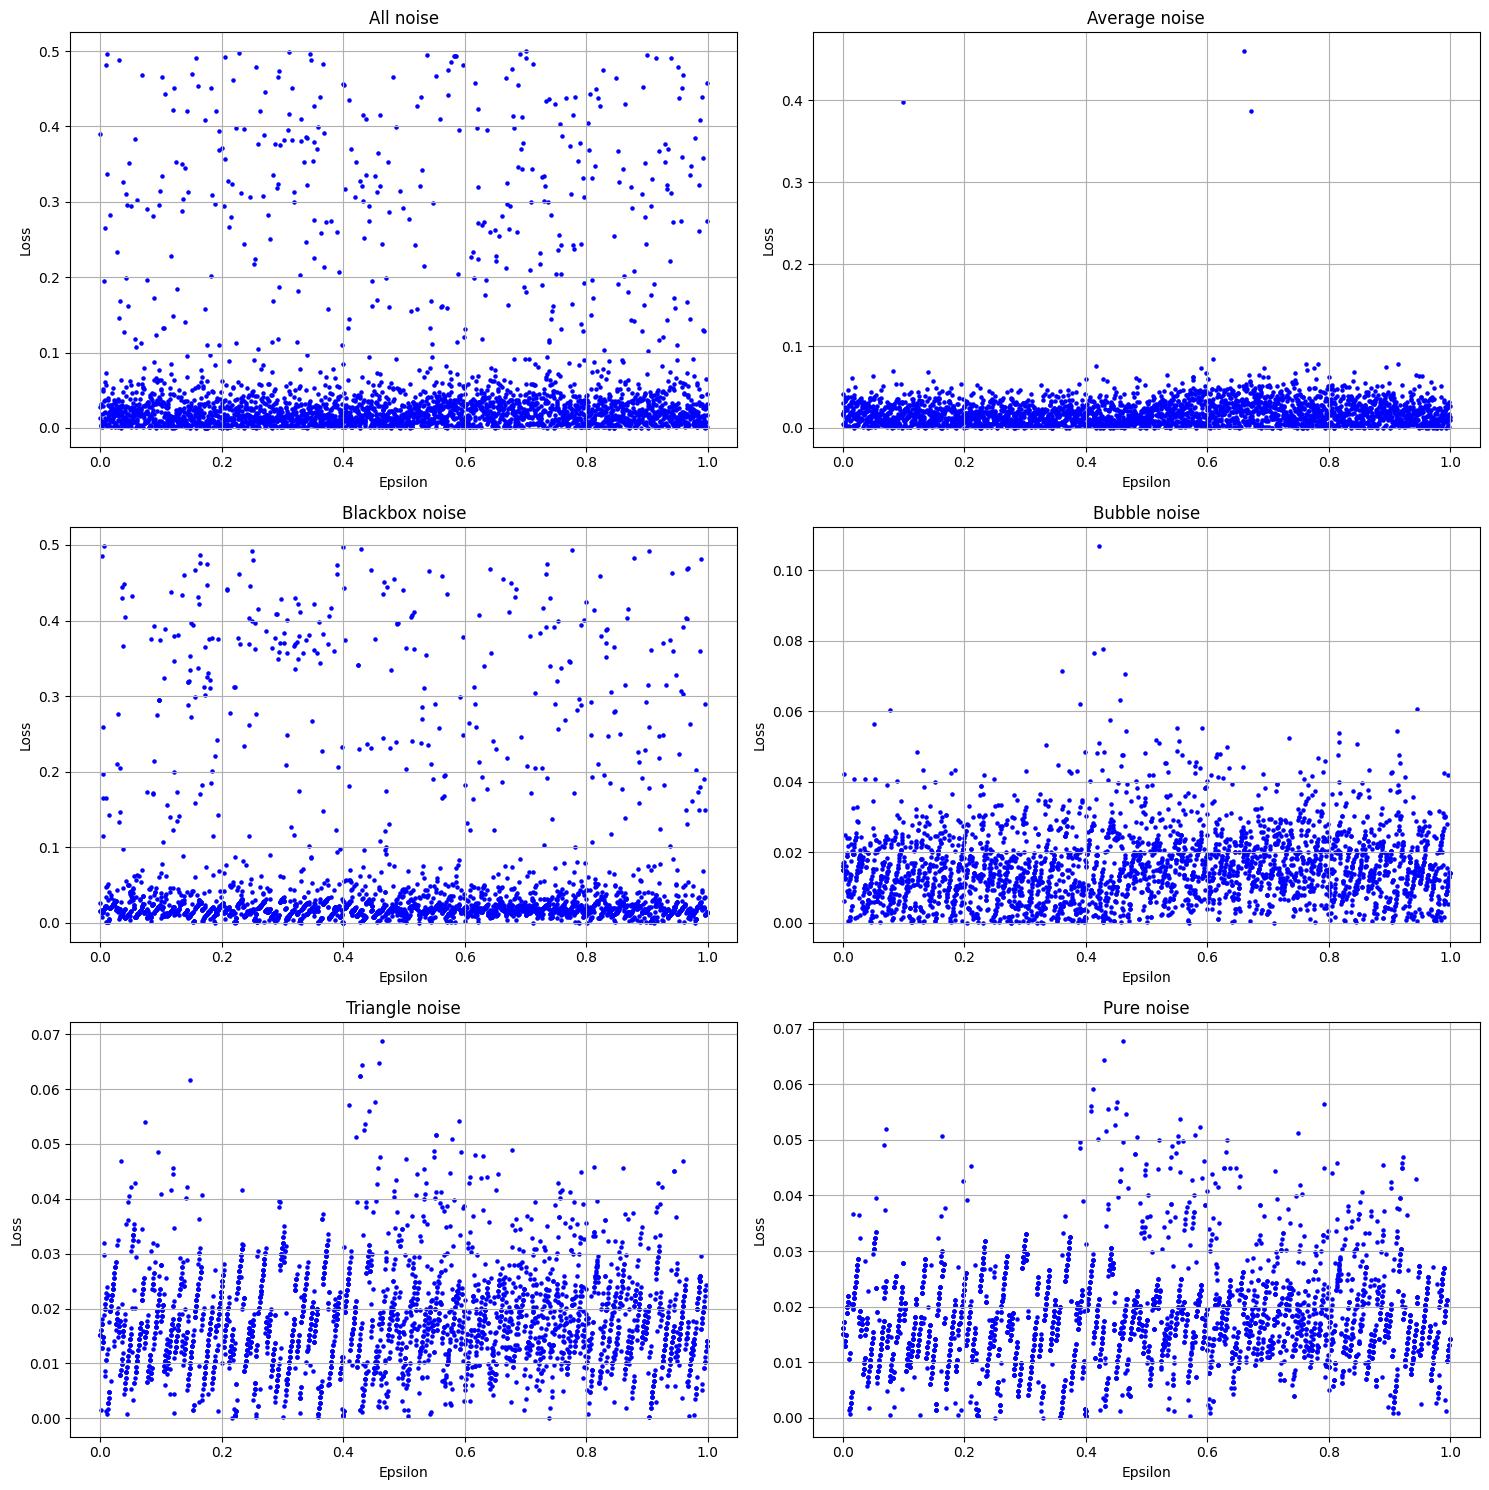

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for ax, (name, df) in zip(axes.ravel(), exact_dfs.items()):
    df_sorted = df.sort_values(by="epsilon")
    ax.scatter(df_sorted["epsilon"], df_sorted["loss"], label=name, color="blue", s=5)
    ax.set_title(name.replace("_", " ").capitalize())
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Loss")
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### The neural network model: direct loss (over and underestimation) ###

In [7]:
def adjusted_plot_loss_distribution(df, title, ax):
    # Calculate the adjusted loss based on the new logic
    def calculate_adjusted_loss(row):
        # Calculate the absolute difference
        absolute_difference = abs(row["predicted"] - row["epsilon"])
        # Considering the cyclic nature, find the minimum difference
        adjusted_loss = min(absolute_difference, 1 - absolute_difference)

        # Determine if it's an underestimation or overestimation
        if row["predicted"] < row["epsilon"]:
            if (
                row["epsilon"] - row["predicted"] > 0.5
            ):  # the values are on opposite sides of the cycle
                adjusted_loss = abs(adjusted_loss)  # it's an overestimation
            else:
                adjusted_loss = -abs(adjusted_loss)  # it's an underestimation
        else:
            if (
                row["predicted"] - row["epsilon"] > 0.5
            ):  # the values are on opposite sides of the cycle
                adjusted_loss = -abs(adjusted_loss)  # it's an underestimation
            else:
                adjusted_loss = abs(adjusted_loss)  # it's an overestimation

        return adjusted_loss

    df["adjusted_loss"] = df.apply(calculate_adjusted_loss, axis=1)
    # Plot
    ax.scatter(df["epsilon"], df["adjusted_loss"], alpha=0.5)
    ax.axhline(0, color="red", linestyle="--", linewidth=0.7)
    ax.set_title(title)
    ax.set_xlabel("True Value")
    ax.set_ylabel("Adjusted Loss")
    ax.set_ylim(-0.5, 0.5)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

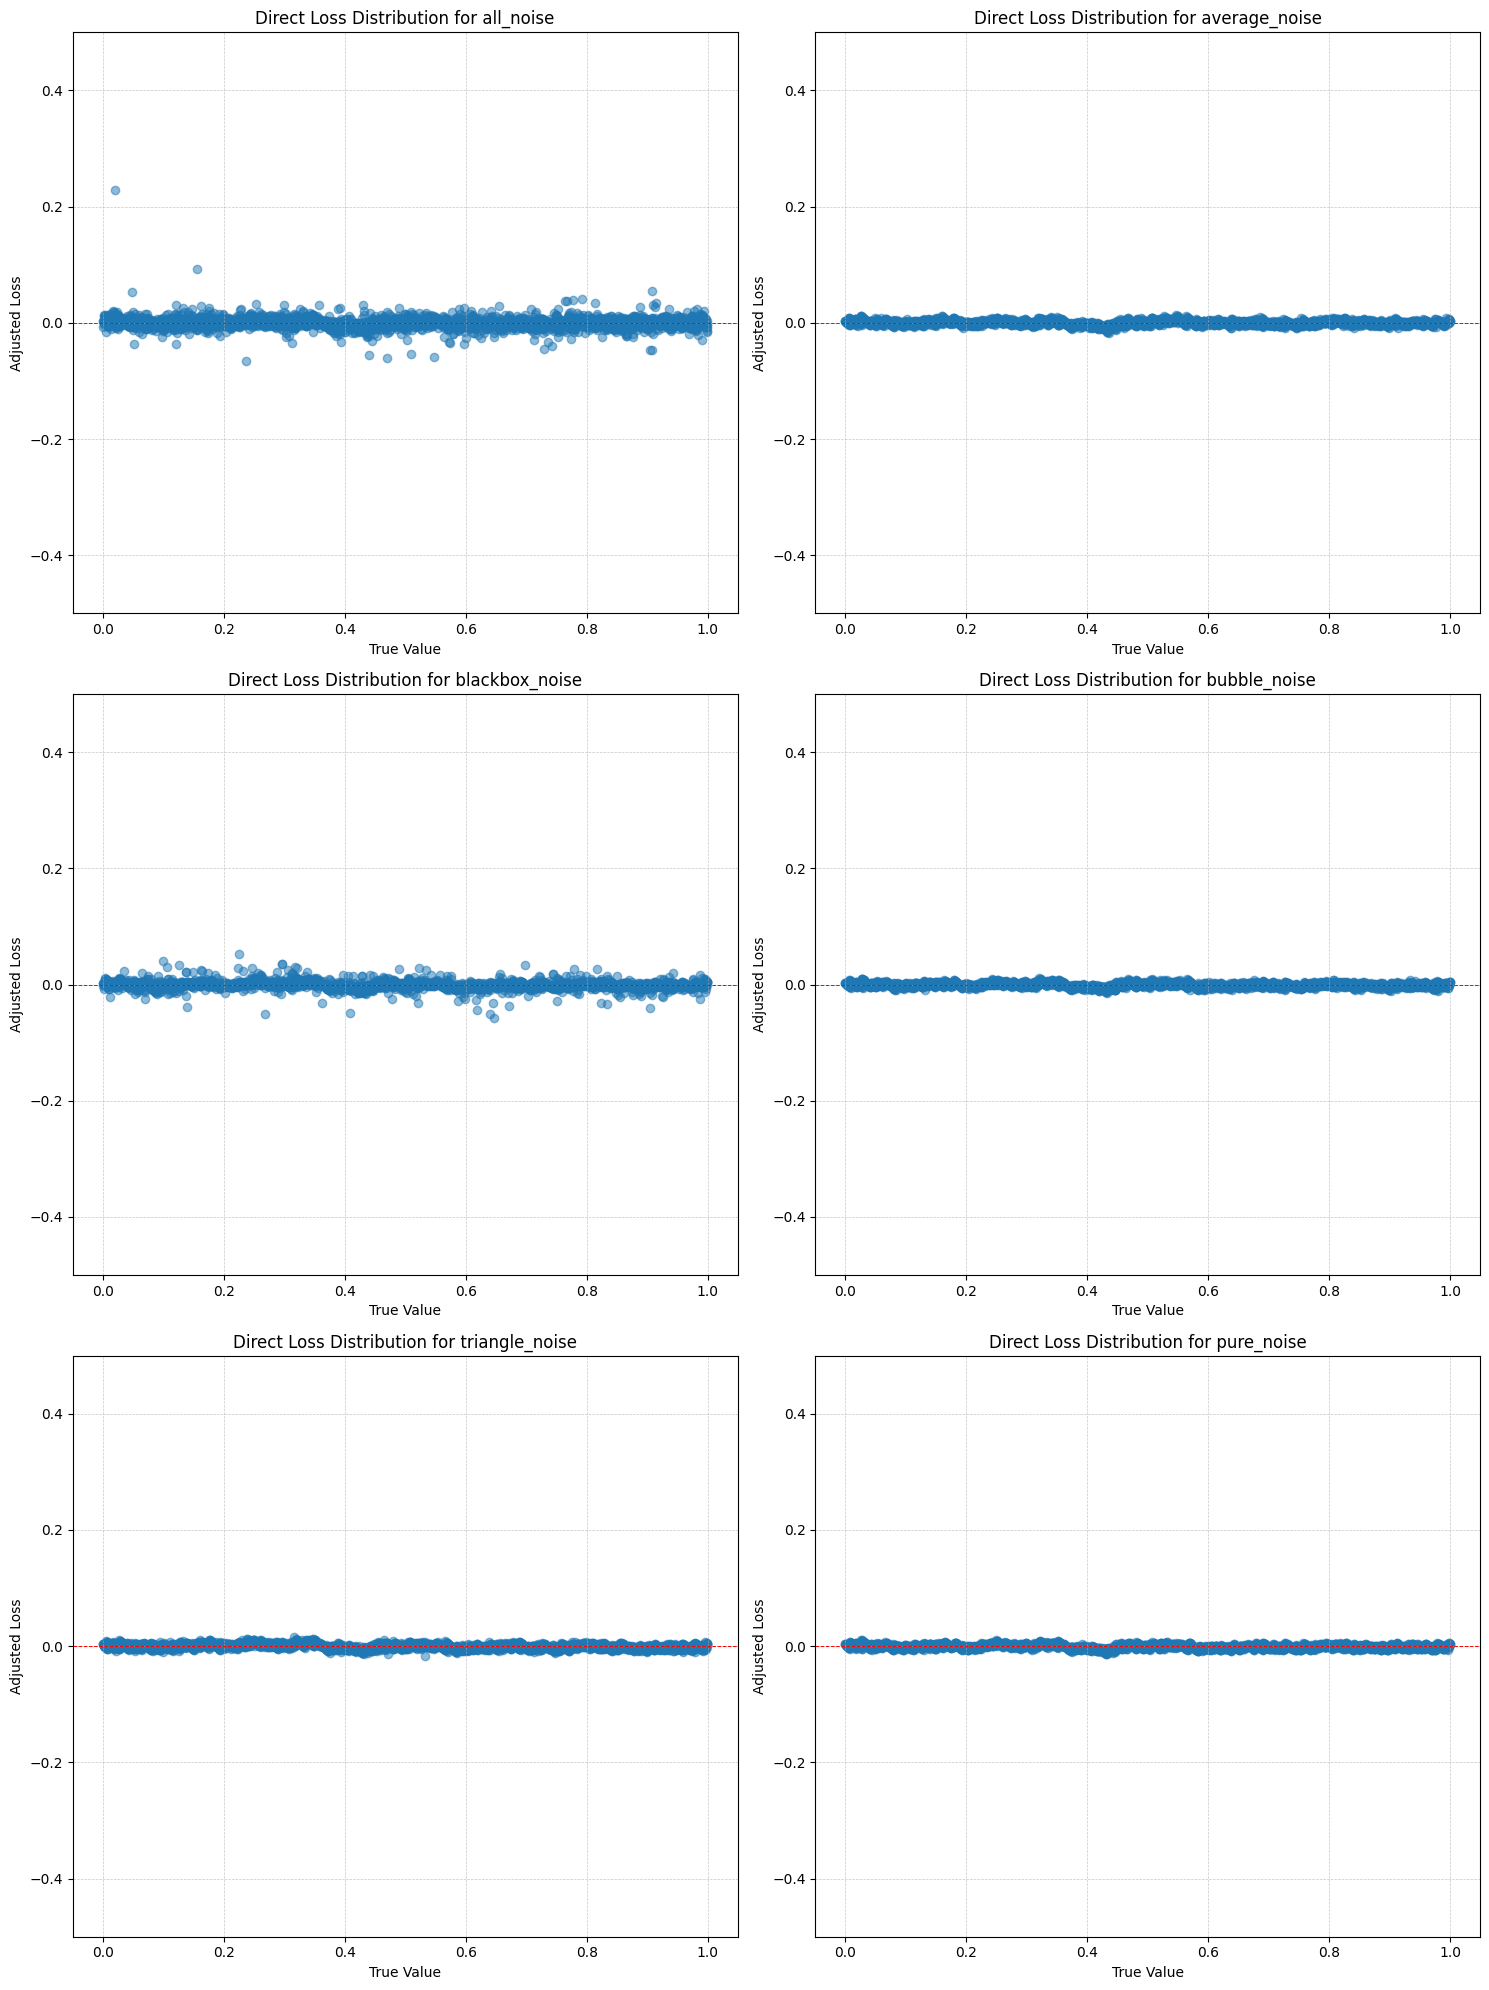

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))  # Adjust the figure size as needed
axs = axs.ravel()

for i, (title, df) in enumerate(dfs.items()):
    adjusted_plot_loss_distribution(df, f"Direct Loss Distribution for {title}", axs[i])

plt.tight_layout()
plt.show()

In [9]:
def compute_statistics(df):
    avg_loss = df["loss"].mean()
    std_dev = df["loss"].std()
    conf_33 = df["loss"].quantile(0.33)
    conf_66 = df["loss"].quantile(0.66)
    return avg_loss, std_dev, conf_33, conf_66


statistics = {title: compute_statistics(df) for title, df in dfs.items()}
statistics_df = pd.DataFrame(
    statistics,
    index=["Average Loss", "Standard Deviation", "33% Confidence", "66% Confidence"],
).transpose()
statistics_df

Average Loss  Standard Deviation  33% Confidence  \
all_noise           0.005870            0.007469           0.003   
average_noise       0.002946            0.002334           0.002   
blackbox_noise      0.004058            0.004944           0.002   
bubble_noise        0.002823            0.002186           0.002   
triangle_noise      0.003161            0.002470           0.002   
pure_noise          0.002655            0.002045           0.001   

                66% Confidence  
all_noise                0.006  
average_noise            0.004  
blackbox_noise           0.004  
bubble_noise             0.003  
triangle_noise           0.004  
pure_noise               0.003

### The exact method: direct loss (over and underestimation) ###

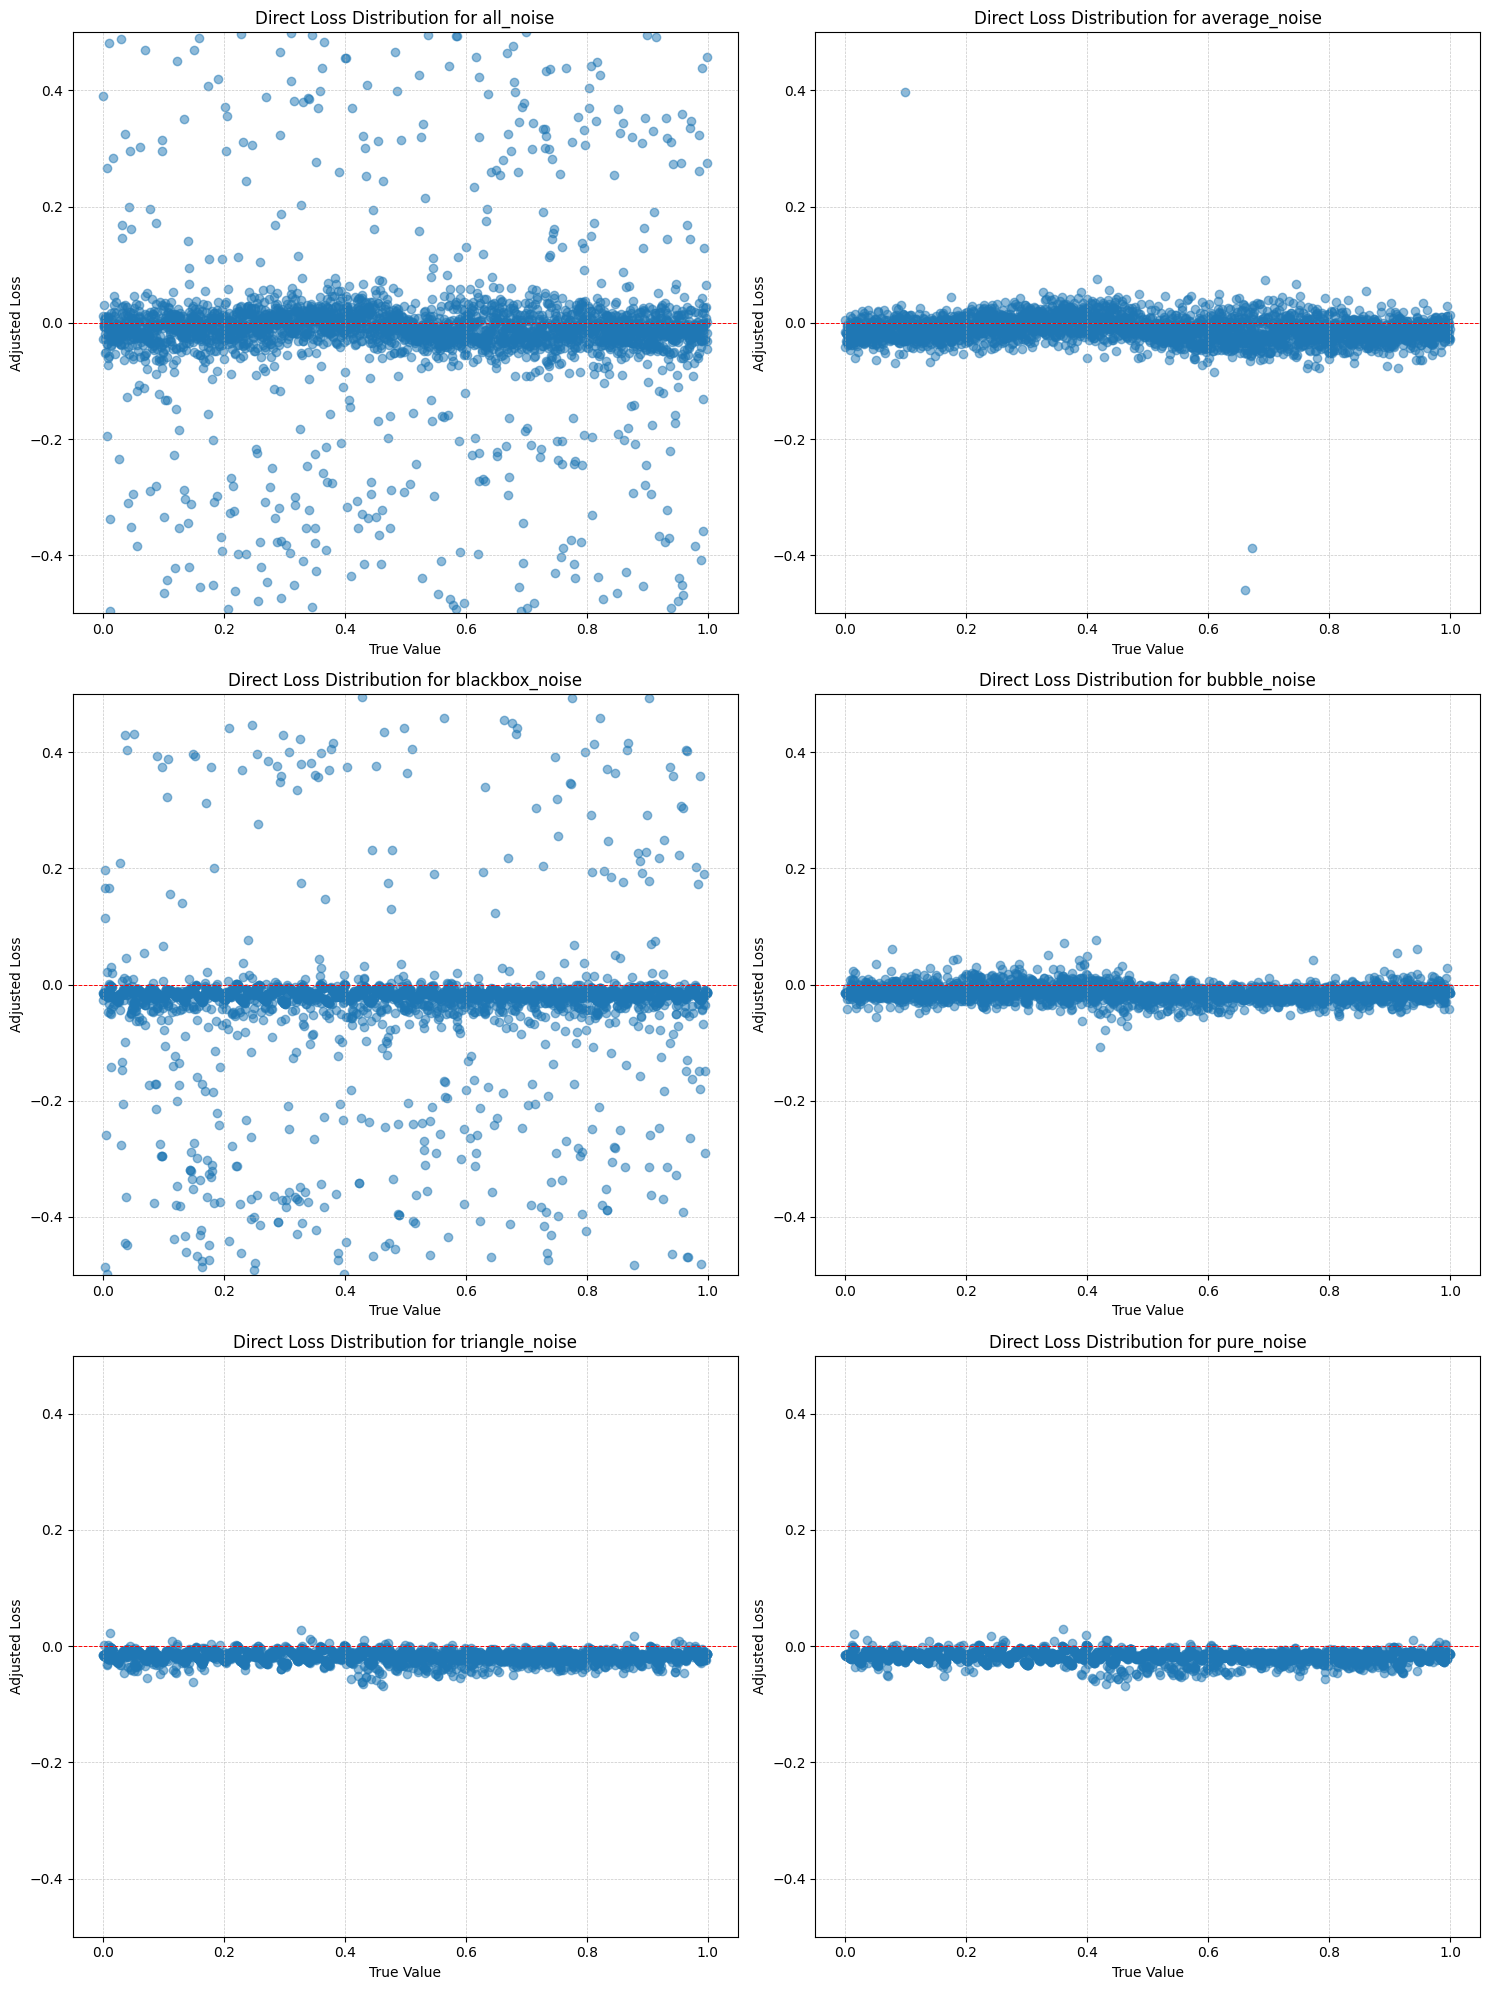

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
axs = axs.ravel()

for i, (title, df) in enumerate(exact_dfs.items()):
    adjusted_plot_loss_distribution(df, f"Direct Loss Distribution for {title}", axs[i])

plt.tight_layout()
plt.show()

In [11]:
statistics = {title: compute_statistics(df) for title, df in exact_dfs.items()}
statistics_df = pd.DataFrame(
    statistics,
    index=["Average Loss", "Standard Deviation", "33% Confidence", "66% Confidence"],
).transpose()
statistics_df

Average Loss  Standard Deviation  33% Confidence  \
all_noise           0.057040            0.102695        0.013355   
average_noise       0.019024            0.018619        0.010101   
blackbox_noise      0.053319            0.098568        0.015224   
bubble_noise        0.016064            0.010359        0.010818   
triangle_noise      0.017748            0.008993        0.013406   
pure_noise          0.017791            0.008945        0.013570   

                66% Confidence  
all_noise             0.031064  
average_noise         0.022509  
blackbox_noise        0.024640  
bubble_noise          0.018848  
triangle_noise        0.020074  
pure_noise            0.019983

### Comparison between NN model and exact method ###

In [12]:
def plot_adjusted_loss_distribution(df1, df2, title1, title2):
    def calculate_adjusted_loss(row):
        absolute_difference = abs(row["predicted"] - row["epsilon"])
        adjusted_loss = min(absolute_difference, 1 - absolute_difference)
        if row["predicted"] < row["epsilon"]:
            if row["epsilon"] - row["predicted"] > 0.5:
                adjusted_loss = abs(adjusted_loss)
            else:
                adjusted_loss = -abs(adjusted_loss)
        else:
            if row["predicted"] - row["epsilon"] > 0.5:
                adjusted_loss = -abs(adjusted_loss)
            else:
                adjusted_loss = abs(adjusted_loss)
        return adjusted_loss

    df1["adjusted_loss"] = df1.apply(calculate_adjusted_loss, axis=1)
    df2["adjusted_loss"] = df2.apply(calculate_adjusted_loss, axis=1)
    y_limit_adjusted = (
        0.5  # slightly larger than the maximum loss for better visualization
    )

    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    axs[0].scatter(df1["epsilon"], df1["adjusted_loss"], alpha=0.5)
    axs[0].axhline(0, color="red", linestyle="--", linewidth=0.7)
    axs[0].set_title(title1)
    axs[0].set_xlabel("True Value")
    axs[0].set_ylabel("Adjusted Loss")
    axs[0].set_ylim(-y_limit_adjusted, y_limit_adjusted)
    axs[0].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    axs[1].scatter(df2["epsilon"], df2["adjusted_loss"], alpha=0.5)
    axs[1].axhline(0, color="red", linestyle="--", linewidth=0.7)
    axs[1].set_title(title2)
    axs[1].set_xlabel("True Value")
    axs[1].set_ylabel("Adjusted Loss")
    axs[1].set_ylim(-y_limit_adjusted, y_limit_adjusted)
    axs[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

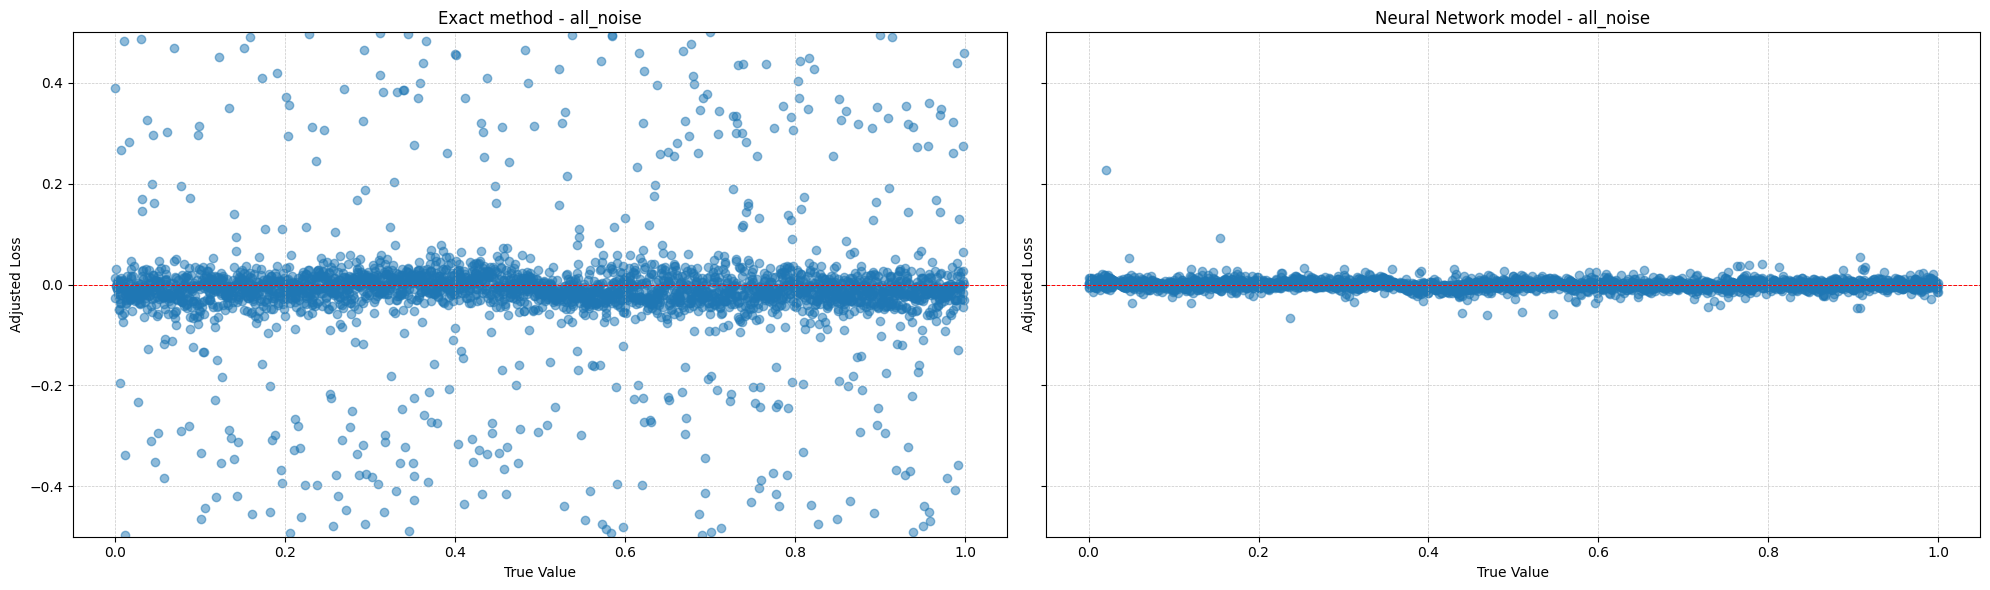

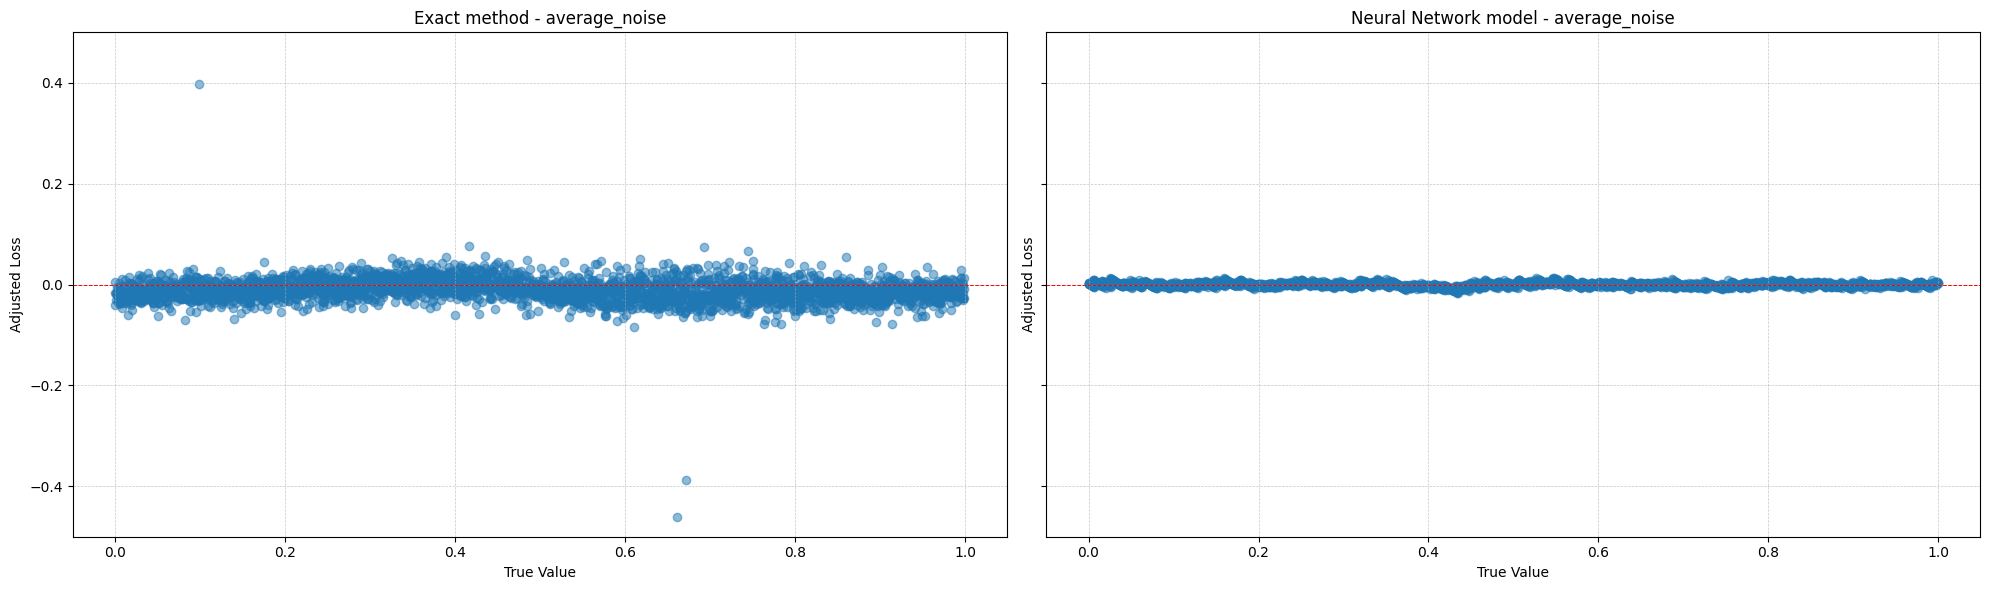

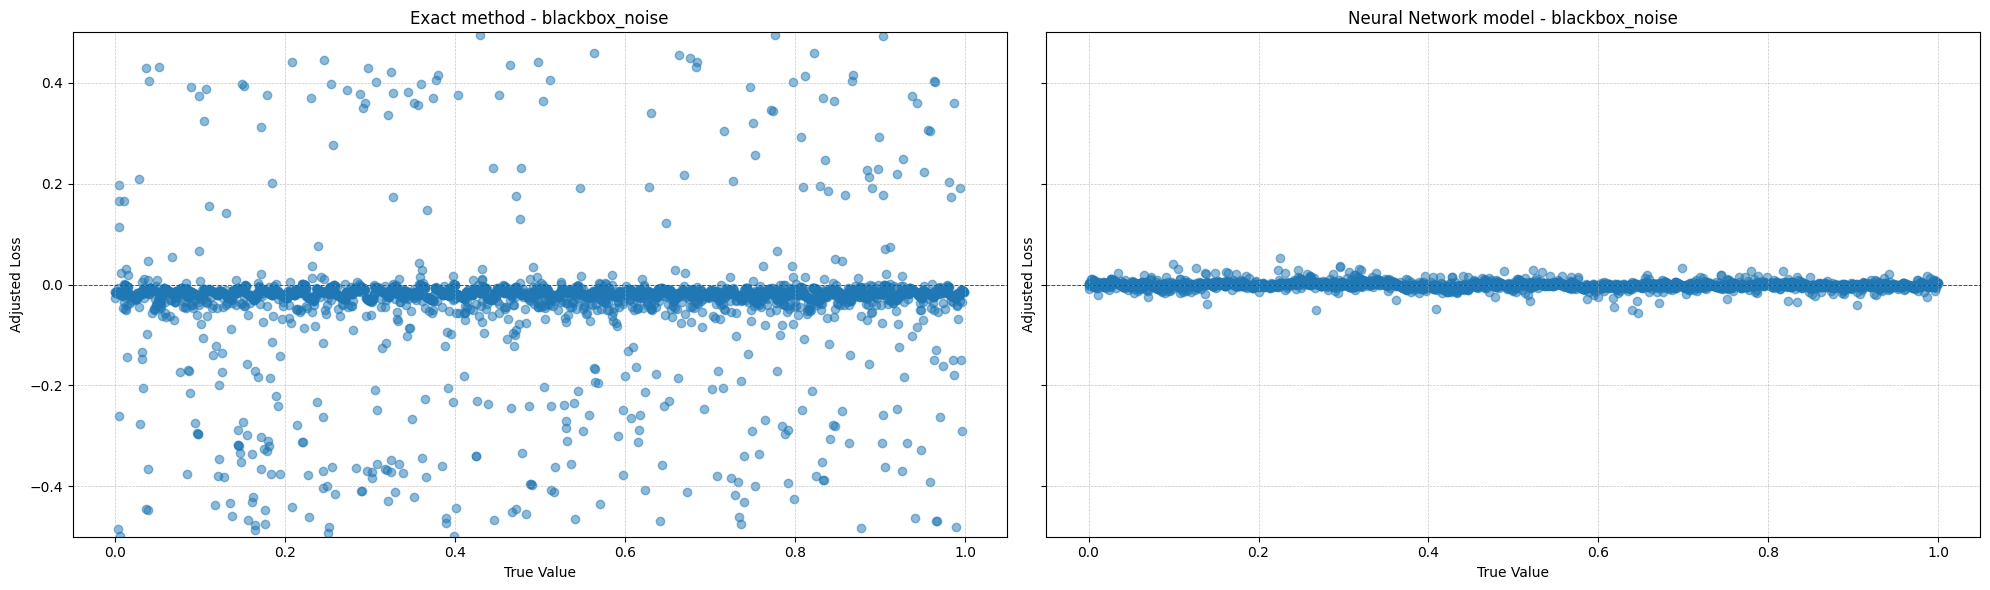

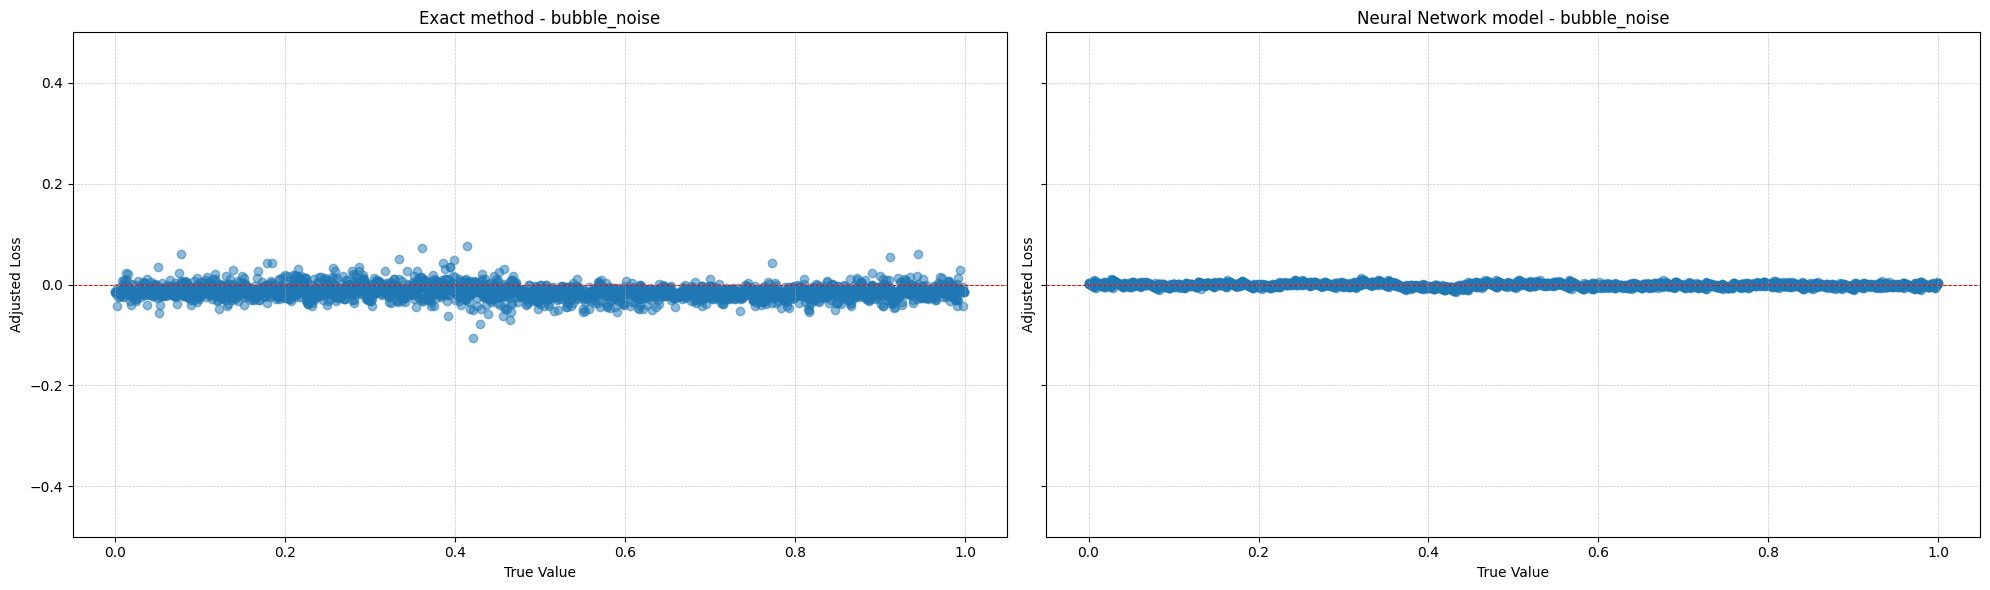

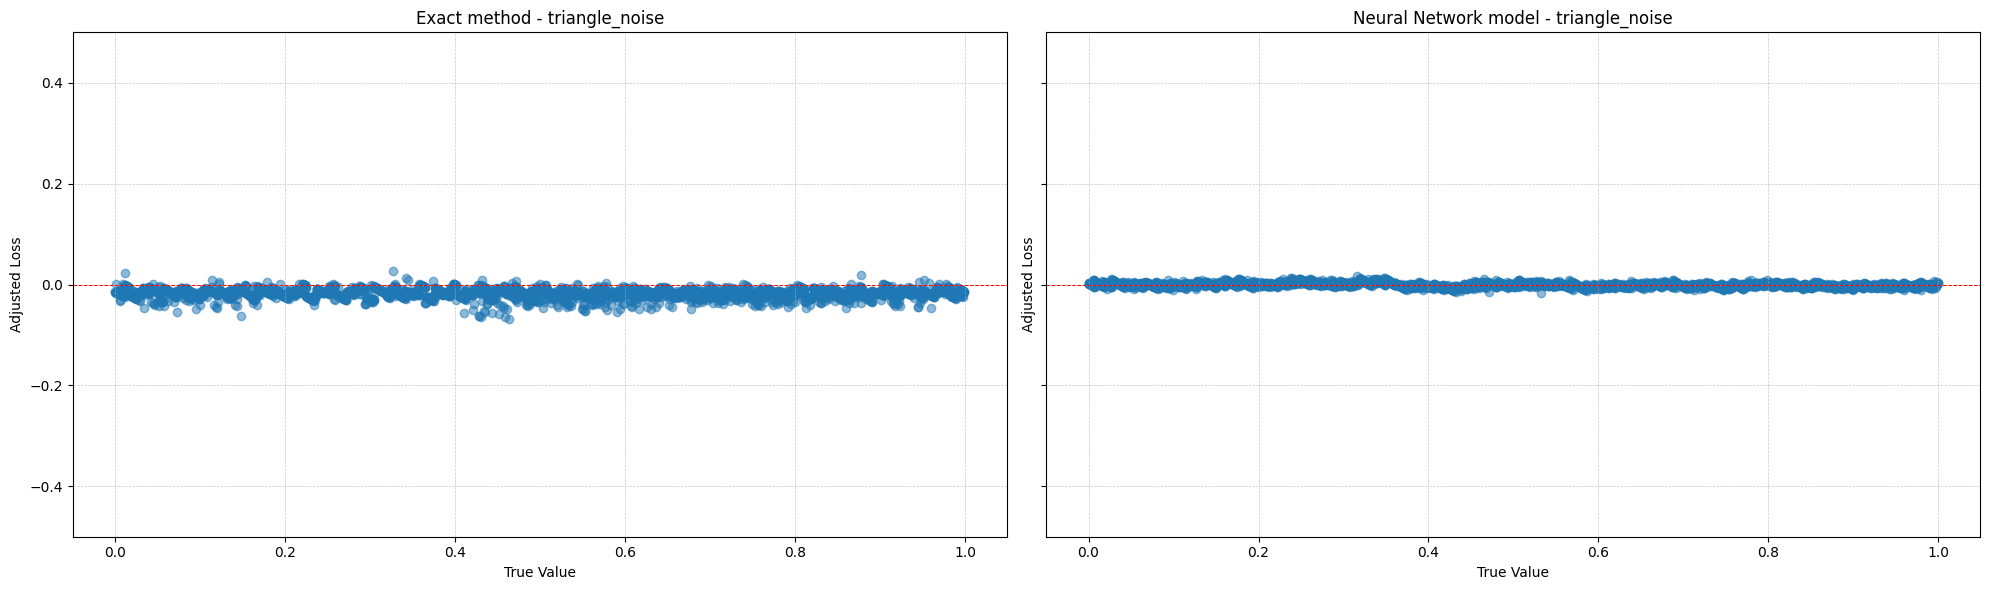

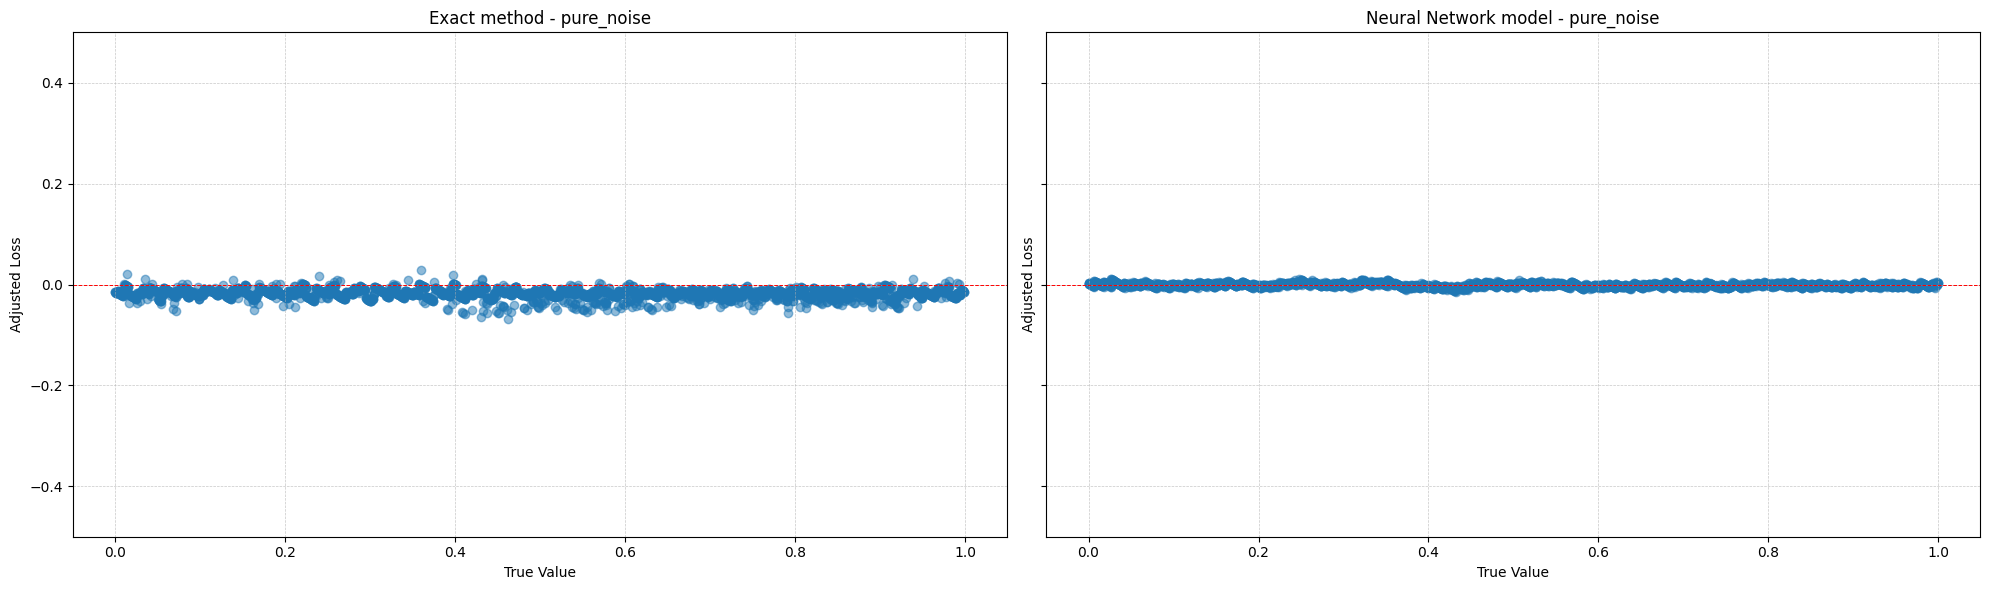

In [13]:
titles = exact_dfs.keys()
for exact, nn, title in zip(exact_dfs, dfs, titles):
    plot_adjusted_loss_distribution(
        exact_dfs[exact],
        dfs[nn],
        f"Exact method - {title}",
        f"Neural Network model - {title}",
    )

## Neural network model explainability #

Below are shown visulization that points which parts of the input image were the most important for the model during the prediction. The darker area, the more important it was for the model.

In [14]:
import torch.nn as nn
import torch
import torchvision.models as models
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import transforms

In [15]:
model = models.resnet18(pretrained=True)
classifier = nn.Sequential(
    nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.3), nn.ReLU(), nn.Linear(512, 1000)
)
model.fc = classifier
model_path = "../models/final_model_best.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))

c:\Users\djankows\Documents\Artificial Intelligence\topography\topography-public\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\djankows\Documents\Artificial Intelligence\topography\topography-public\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [16]:
class ImageDataset(Dataset):
    def __init__(self, path: str, parameters: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array(
            [path + filename for filename in parameters["filename"].to_numpy()]
        )
        self.labels = parameters["epsilon"].to_numpy()
        self.transform = transform

    def __getitem__(self, inx):
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon * 1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)

    def __len__(self):
        return len(self.image_paths)


transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)


def prepare_image_for_prediction(image_path: str) -> torch.Tensor:
    df = pd.DataFrame({"filename": [image_path.split("/")[-1]], "epsilon": [0]})
    dataset = ImageDataset(
        path=image_path.rsplit("/", 1)[0] + "/", parameters=df, transform=transform
    )
    image_tensor, _ = dataset[0]
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor


def prediction_to_real_value(prediction: torch.Tensor) -> float:
    """
    Convert the model's prediction tensor to a real value in the range [0.0, 1.0].

    Parameters:
    - prediction (torch.Tensor): The prediction tensor, typically of shape (batch_size, 1000).

    Returns:
    - float: The real value in the range [0.0, 1.0].
    """
    max_index = torch.argmax(prediction, dim=1).item()
    real_value = max_index / 1000.0
    return real_value

In [17]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
sample_image = prepare_image_for_prediction("../data/samples/all_00004.png")
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(
    sample_image, target=torch.argmax(model(sample_image), 1), n_steps=30
)

In [19]:
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list(
    "custom blue", [(0, "#ffffff"), (0.25, "#000000"), (1, "#000000")], N=256
)

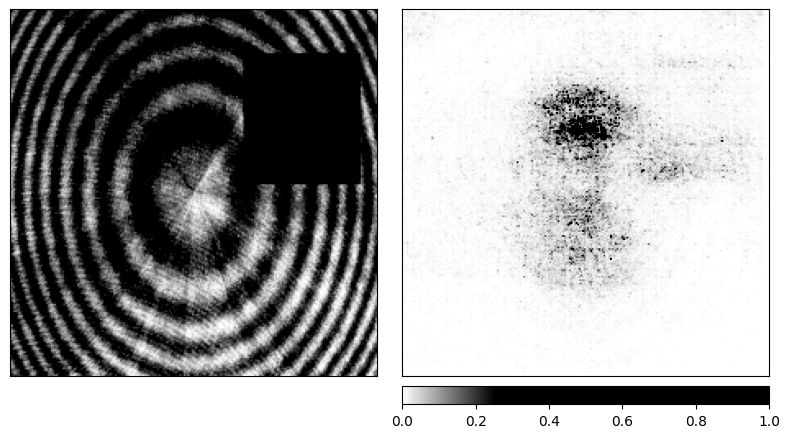

In [20]:
noise_tunnel = NoiseTunnel(integrated_gradients)
image_np = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
attributions_ig_nt = noise_tunnel.attribute(
    sample_image,
    nt_samples=10,
    nt_type="smoothgrad_sq",
    target=torch.argmax(model(sample_image), 1),
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    image_np,
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True,
)

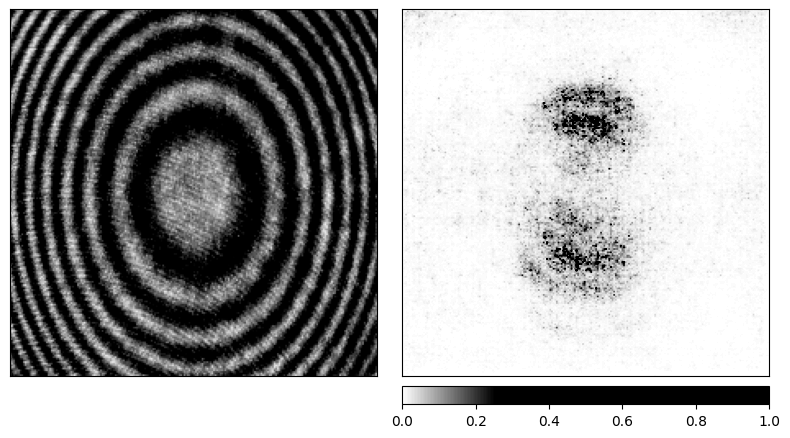

In [22]:
sample_image = prepare_image_for_prediction("../data/samples/average_00998.png")
attributions_ig = integrated_gradients.attribute(
    sample_image, target=torch.argmax(model(sample_image), 1), n_steps=30
)
image_np = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
attributions_ig_nt = noise_tunnel.attribute(
    sample_image,
    nt_samples=10,
    nt_type="smoothgrad_sq",
    target=torch.argmax(model(sample_image), 1),
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    image_np,
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True,
)

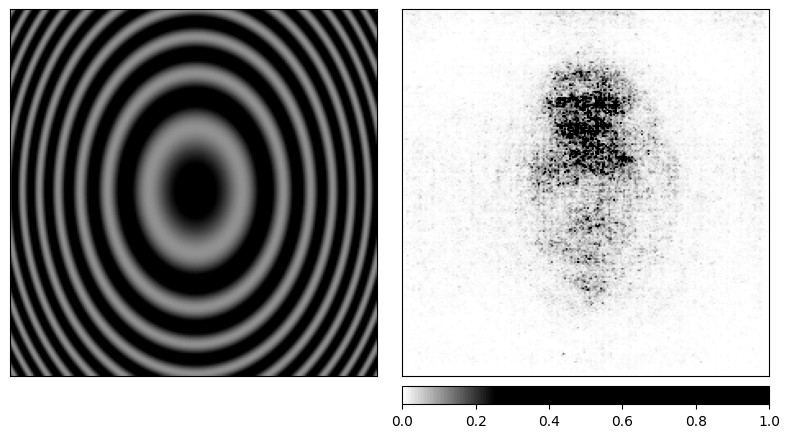

In [23]:
sample_image = prepare_image_for_prediction("../data/samples/pure_03956.png")
attributions_ig = integrated_gradients.attribute(
    sample_image, target=torch.argmax(model(sample_image), 1), n_steps=30
)
image_np = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
attributions_ig_nt = noise_tunnel.attribute(
    sample_image,
    nt_samples=10,
    nt_type="smoothgrad_sq",
    target=torch.argmax(model(sample_image), 1),
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    image_np,
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True,
)

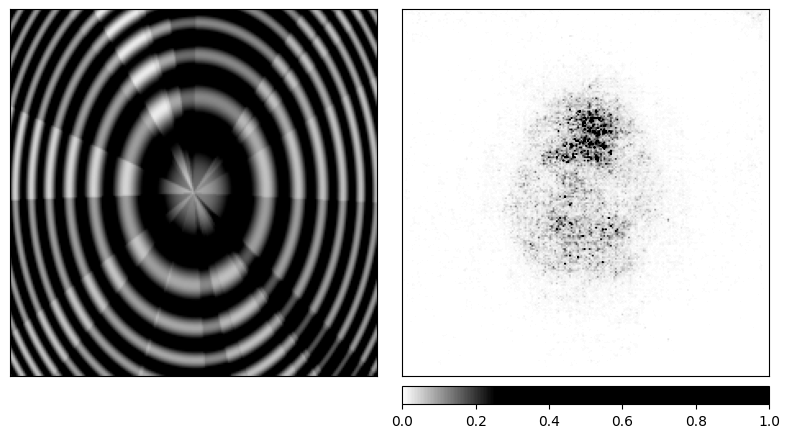

In [24]:
sample_image = prepare_image_for_prediction("../data/samples/pizza_08956.png")
attributions_ig = integrated_gradients.attribute(
    sample_image, target=torch.argmax(model(sample_image), 1), n_steps=30
)
image_np = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
attributions_ig_nt = noise_tunnel.attribute(
    sample_image,
    nt_samples=10,
    nt_type="smoothgrad_sq",
    target=torch.argmax(model(sample_image), 1),
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    image_np,
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True,
)